<center><img src="https://images.twinkl.co.uk/tw1n/image/private/t_630/image_repo/b8/06/t-lf-242-pupil-voice-learning-child-led-learning-peer-assessment-cards_ver_1.jpg" height="100"></center>

# Detección de incoherencias en evaluación por pares

Profesor: Juan Ramón Rico (<juanramonrico@ua.es>)

## Descripción
---
No cabe duda que las redes neuronales han avanzado en tareas donde se usa texto y valores numéricos. Concretametne en las encuestas o en la evaluación por pares es habitual encontrar valores numéricos (libres o sujetos a una escala - Likert) y comentarios de los evaluadores respecto a las secciones evaluadas en forma de texto (feedback).

- Artículo sobre evaluación por pares donde se han usado redes recurrentes entre otras metodologías para detectar incongruencias en las respuestas <https://www.sciencedirect.com/science/article/pii/S0360131519301629?dgcid=author> ha servido como base para esta actividad.
---


# Introducción

El uso de la evaluación por pares para actividades abiertas tiene ventajas tanto para los profesores como para los estudiantes. Los profesores pueden reducir la carga de trabajo del proceso de corrección y los estudiantes logran una mejor comprensión de la materia al evaluar las actividades de sus compañeros. Para facilitar el proceso, es aconsejable proporcionar a los estudiantes una rúbrica sobre la cual realizar la evaluación de sus compañeros; sin embargo, limitarse a proporcionar sólo puntuaciones numéricas es perjudicial, ya que impide proporcionar una retroalimentación valiosa a otros compañeros. Dado que esta evaluación produce dos modalidades de la misma evaluación, a saber, la puntuación numérica y la retroalimentación textual, es posible aplicar técnicas automáticas para detectar inconsistencias en la evaluación, minimizando así la carga de trabajo de los profesores para supervisar todo el proceso.

Esta actividad estará enfocada en solo una parte de la detección de incongruencias que será la predicción de calificación de una sección usando únicamente información textual.

# Conjunto de datos

Los datos que vamos a utilizar para esta se pueden descargar en un archivo tipo CSV donde figura:

- `activity`: es la actividad desarrollada, en este caso 1 o 2. Son actividades independientes y los más lógico es entrenar modelos (redes neuronales) independientes para cada una;
-  `year`:  año de comienzo del curso académico estudiado;
- `group`: con valores de 1 si es de mañana o 2 si es de tarde;
- `evaluator`: identificador interno del evaluador para una actividad concreta (la actividad 1 o la 2, de forma excluyente);
- `work` : es el identificador del trabajo. La entrega se realizaba mediante una URL por lo que hay ocasiones en la que es privada o no accesible y no se ha podido evaluar.
- `secction`: número de sección que se evalua dentro de cada actividad, o 'grade1', 'grade2' cuando se trata de la nota final del trabajo evaluado.
- `value`: valor numérico comprendido entre 0 y 3. Siendo 0 no realizado o realizado incorrectamente y 3 realizado correctamente. Este número puede tener decimales debido a que corresponde al promedio de los valores de la sección.
- `feedback`: texto libre correspondiente a las recomendaciones que el evaluador realiza en cada sección. Puede estar en blanco lo que indica que no se realizan comentarios y corresponde a que todo está correcto.

Para esta actividad necesitaremos `activity`, `value` y `feeback`.

In [ ]:
import numpy as np
import pandas as pd

data = pd.read_csv('https://www.dlsi.ua.es/~juanra/UA/dataset/dcadep/dcadep_melt_grades.csv.gz', sep='\t', decimal=',')
data.fillna('', inplace=True) # Reemplazar los valores en blanco por cadena vacías
data = data.sample(frac=1, random_state=123) # Barajar los ejemplos de entrada (filas de la tabla)
display(data.head())
data.dtypes

,activity,year,group,evaluator,work,section,value,feedback
23557,2,2015,2,103,59,7,2.0,Faltan datos para completar la página
5292,1,2016,2,304,141,3,3.0,Poco original y trabajo muy básico.
22491,2,2016,2,333,137,6,3.0,Correcto
9655,1,2015,1,12,13,grade1,9.3,
25778,2,2016,1,204,88,grade2,9.4,


,0
activity,int64
year,int64
group,int64
evaluator,int64
work,int64
section,object
value,float64
feedback,object


El atributo `section` contiene los identificadores de las diferentes secciones, así como las calificación final (`grade1` y `grade2` cuyos valores están entre 0 y 10) según la actividad. Esta actividad se tiene que evaluar por separado para la actividad 1 o 2 usando únicamente las secciones numéricas (1,2,3,4,5,6 y 7) cuyos valores oscilan entre 0 y 3.

In [ ]:
np.sort(data['section'].unique())

array(['1', '2', '3', '4', '5', '6', '7', 'grade1', 'grade2'],
      dtype=object)

# Visualizar las valoraciones

,0
activity,
1,"[[Axes(0.125,0.11;0.336957x0.77), Axes(0.56304..."
2,"[[Axes(0.125,0.11;0.336957x0.77), Axes(0.56304..."


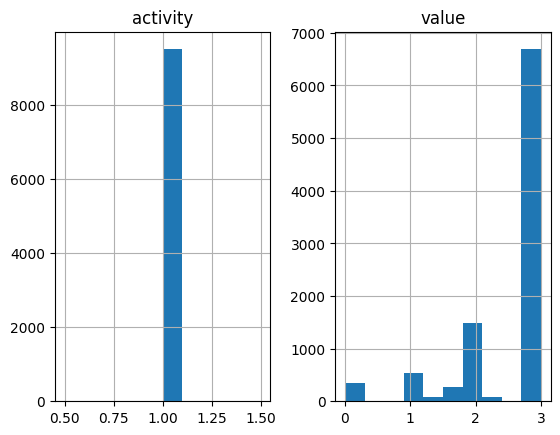

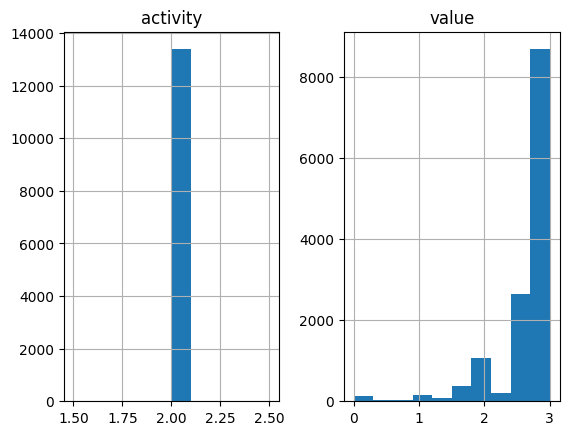

In [ ]:
data[data['section'].isin(['1','2','3','4','5','6','7'])][['activity','value']].groupby('activity').hist()

Podemos ver como la mayoría de valores son cercanos a 3. No obstante tenemos que predecir cuando este valor va disminuyendo atendiendo a las palabras usadas en el contexto restringido de cada actividad.

# Preprocesar el texto

Es necesario preprocesar el texto para descartar símbolos de puntuación, valorar igualmente a palabras en mayúscula y minúscula y extraeer la raiz de las palabras (lemas) para procesarlas como iguales.

Para ello usaremos bibliotecas de procesamiento de lenguaje natural (PLN).

In [ ]:
import nltk
nltk.download('stopwords')

from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')
stemmer = SnowballStemmer("spanish",ignore_stopwords=True)

preprocessed_feedback = []
for i in data.feedback:
  tokens = [stemmer.stem(word) for word in tokenizer.tokenize(i.lower())]
  preprocessed_feedback.append(np.array(' '.join(tokens)))

data['feedback prep'] = preprocessed_feedback
data['feedback prep'] = data['feedback prep'].astype('str')
data.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,activity,year,group,evaluator,work,section,value,feedback,feedback prep
23557,2,2015,2,103,59,7,2.0,Faltan datos para completar la página,falt dat para complet la pagin
5292,1,2016,2,304,141,3,3.0,Poco original y trabajo muy básico.,poco original y trabaj muy basic
22491,2,2016,2,333,137,6,3.0,Correcto,correct
9655,1,2015,1,12,13,grade1,9.3,,
25778,2,2016,1,204,88,grade2,9.4,,


In [ ]:
data.dtypes

,0
activity,int64
year,int64
group,int64
evaluator,int64
work,int64
section,object
value,float64
feedback,object
feedback prep,object


# Convertir datos de entrenamiento a la forma correcta

En este caso los datos de tipo texto hay transformarlos en secuencias de número que recibirá la red neuronal.

- En el siguiente enlace <https://www.programcreek.com/python/example/106871/keras.preprocessing.text.Tokenizer> hay varios ejemplos de como convertir el texto que ya tenemos preprocesado a secuencias de números;
- De la secuencia de números hay que aplicar `pad_sequences` como truco para igualar la longitud de todas las secuencias de entreada. Nos facilita la tarea de entrenar un red recurrente con `Keras`.


In [ ]:
# Seleccionar la actividad 1 y sus secciones, ya que se evaluan por separado. La actividad 2 se seleccionaría por separado
new_data = data[(data['activity']==1) & data['section'].isin(['1','2','3','4','5','6','7'])]

X = ... # Valores de new_data['feedback prep'] con el padding aplicado
y = new_data['value'].values


# Creando la red neuronal

Se han preprocesado los datos y los hemos convertido al formato correcto. Ahora tenemos que diseñar nuestra red para entrenarla y realizar las predicciones.

En el caso de codificar la entrada como un conjunto de palabras (Bag of Words) tendremos un vector de entrada con todas las palabras posibles del vocabulario. Cada posición del vector representa si está presente la palabra o no, el número de veces que se repite, o el valor TF-IDF correspondiente. La dimensión incial de la red cuando entrena será de `(batch_size, vocabulary_len)`.

Otro caso diferente corresponde a una codificación del la entrada atendiendo a una secuencia. Cada valor (entero) del vector de entrada representa a una palabra y la entrada cumple con estas tres dimensiones `(batch_size, time_steps, seq_len)` que necesita una red recurrente.

In [ ]:
maxlen = 100
# tras tokenizar y hacer pad_sequences(...)
# X.shape == (n_ejemplos, maxlen)

# Ahora:
input_shape = (maxlen,)     # <-- aquí llenas "RELLENAR"
vocab_size   = len(tokenizer.word_index) + 1
embedding_dim = 100

model = Sequential()
# 1) capa de Input para respetar input_shape
model.add(layers.Input(shape=input_shape, dtype='int32'))
# 2) embedding: convierte índices en vectores
model.add(layers.Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    input_length=input_shape[0]    # coincide con maxlen
))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))         # regresión 0–3

model.compile(
    optimizer='adam',
    loss='mean_absolute_error',
    metrics=['mae']
)


AttributeError: 'RegexpTokenizer' object has no attribute 'word_index'

# Entrenamiento del modelo

Vamos a dividir el conjunto en entrenamiento y test para comprobar nuestro modelo. Para ello tenemos que elegir un tipo de actividad (1 o 2), sus valores y feedback (preprocesado).

In [ ]:
current_activity = 1 # 1 or 2

new_data = data[data.activity==current_activity]
n = int(len(new_data)*0.9)

X_train, X_test = X[:n], X[n:]
y_train, y_test = y[:n], y[n:]

In [ ]:
# Para verificar que el modelo entrena correctamente crearemos un conjunto de validación del 10% de los datos con el parámetro ()
model.fit(X_train, y_train, epochs = 50, validation_split=0.1, batch_size = 32)

# Predicciones con el test

Las predicciones  se realizan entre 0 y 3 que son los valores mínimos y máximo establecidos para cada valorar cada ítem.

In [ ]:
y_pred = np.clip(model.predict(X_test), 0, 3)

# Visualización de resultados

Tenemos que crear un DataFrame con el texto del feedback, valores reales, los predichos y su diferencia para apreciar las diferencias.